In [1]:
import torch.utils.data as data

import random
import numbers
from PIL import Image, ImageMath
import os
import os.path
import numpy as np
import struct
import math

import torch
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

import faiss
import time

import pcl
from PIL import Image, ImageDraw
import faiss

import timeit

%matplotlib qt5

In [2]:
class KNNBuilder_GPU:
    def __init__(self, k):
        self.k = k
        self.dimension = 3
        
        # we need only a StandardGpuResources per GPU
        self.res = faiss.StandardGpuResources()
        self.res.setTempMemoryFraction(0.1)
        self.flat_config = faiss.GpuIndexFlatConfig()
        self.flat_config.device = 0
        
    def build_nn_index(self, database):
        '''
        :param database: numpy array of Nx3
        :return: Faiss index, in CPU
        '''
#         index = faiss.GpuIndexFlatL2(self.res, self.dimension, self.flat_config)  # dimension is 3
        index_cpu = faiss.IndexFlatL2(self.dimension)
        index = faiss.index_cpu_to_gpu(self.res, int(0), index_cpu)
        
        index.add(database)
        return index
    
    def search_nn(self, index, query, k):
        '''
        :param index: Faiss index
        :param query: numpy array of Nx3
        :return: D: numpy array of Nxk
                 I: numpy array of Nxk
        '''
        D, I = index.search(query, k)
        return D, I
    
    def self_build_search(self, x):
        '''

        :param x: numpy array of Nxd
        :return: D: numpy array of Nxk
                 I: numpy array of Nxk
        '''
        x = np.ascontiguousarray(x, dtype=np.float32)
        index = self.build_nn_index(x)
        D, I = self.search_nn(index, x, self.k)
        return D, I
    

class KNNBuilder:
    def __init__(self, k):
        self.k = k
        self.dimension = 3

    def build_nn_index(self, database):
        '''
        :param database: numpy array of Nx3
        :return: Faiss index, in CPU
        '''
        index = faiss.IndexFlatL2(self.dimension)  # dimension is 3
        index.add(database)
        return index

    def search_nn(self, index, query, k):
        '''
        :param index: Faiss index
        :param query: numpy array of Nx3
        :return: D: numpy array of Nxk
                 I: numpy array of Nxk
        '''
        D, I = index.search(query, k)
        return D, I

    def self_build_search(self, x):
        '''

        :param x: numpy array of Nxd
        :return: D: numpy array of Nxk
                 I: numpy array of Nxk
        '''
        x = np.ascontiguousarray(x, dtype=np.float32)
        index = self.build_nn_index(x)
        D, I = self.search_nn(index, x, self.k)
        return D, I


class FarthestSampler:
    def __init__(self):
        pass

    def calc_distances(self, p0, points):
        return ((p0 - points) ** 2).sum(axis=1)

    def sample(self, pts, k):
        farthest_pts = np.zeros((k, 3))
        farthest_pts[0] = pts[np.random.randint(len(pts))]
        distances = self.calc_distances(farthest_pts[0], pts)
        for i in range(1, k):
            farthest_pts[i] = pts[np.argmax(distances)]
            distances = np.minimum(distances, self.calc_distances(farthest_pts[i], pts))
        return farthest_pts

    

def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)


def plot_pc(pc_np, z_cutoff=70, birds_view=False, color='height', size=0.3, ax=None):
    # remove large z points
    valid_index = pc_np[:, 2] < z_cutoff
    pc_np = pc_np[valid_index, :]

    if ax is None:
        fig = plt.figure(figsize=(9, 9))
        ax = Axes3D(fig)
    if color == 'height':
        c = pc_np[:,1]
        ax.scatter(pc_np[:, 0].tolist(), pc_np[:, 1].tolist(), pc_np[:, 2].tolist(), s=size, c=c, cmap=cm.jet_r)
    elif color == 'reflectance':
        assert False
    else:
        ax.scatter(pc_np[:, 0].tolist(), pc_np[:, 1].tolist(), pc_np[:, 2].tolist(), s=size, c=color)

    axisEqual3D(ax)
    if True == birds_view:
        ax.view_init(elev=0, azim=-90)
    else:
        ax.view_init(elev=-45, azim=-90)
    # ax.invert_yaxis()
    
    return ax

In [3]:
def load_pc_and_pose_kitti(seq, no):
    '''
    return: pc_np: Nx4 - x, y, z, reflectance
    return: pose_np: 4x4
    '''
    pc_np = np.load('/ssd/dataset/odometry/data_odometry_velodyne/numpy/%02d/np_0.20_20480_r50/%06d.npy' % (seq, no))
    pose_np = np.load('/ssd/dataset/odometry/poses/%02d/%06d.npz' % (seq, no))['pose']
    return pc_np, pose_np




def transform_pc(pc, pose, pose_ref):
    '''
    transform pc to the reference frame
    '''
    pc_coord = pc[:, 0:3]  # Nx3
    pc_coord_homo = np.concatenate((pc_coord, np.ones((pc_coord.shape[0], 1))), axis=1)  # Nx4
    pc_coord_homo_transposed = np.transpose(pc_coord_homo)  # 4xN

    pc_coord_ref_transposed = np.dot(np.dot(np.linalg.inv(pose_ref), pose), pc_coord_homo_transposed)  # 4xN
    pc_coord_ref = np.transpose(pc_coord_ref_transposed)  # Nx4
    
    if pc.shape[1] == 3:
        pc_ref = pc_coord_ref[:, 0:3]
    else:
        pc_ref = np.concatenate((pc_coord_ref[:, 0:3], pc[:, 3:]), axis=1)
        
    return pc_ref

In [ ]:
# evaluate the accuracy of the ground truth pose
pc_0, pose_0 = load_pc_and_pose_kitti(0, 0)
pc_1, pose_1 = load_pc_and_pose_kitti(0, 3)

pc_0_at_1 = transform_pc(pc_0, pose_0, pose_1)

print(pc_0.shape)
print(pc_0_at_1.shape)

fig = plt.figure(figsize=(9, 9))
ax = Axes3D(fig)
ax = plot_pc(pc_1, color=[0, 0, 1], ax=ax)
ax = plot_pc(pc_0_at_1, color=[1, 0, 0], ax=ax)
plt.show()


In [ ]:
def make_dataset_kitti(root):
    seq_list = list(range(11))

    # filter or not
    np_folder = 'np_0.20_20480_r50_filtered_sn'
        
    accumulated_sample_num = 0
    sample_num_list = []
    accumulated_sample_num_list = []
    folder_list = []
    for seq in seq_list:
        folder = os.path.join(root, 'data_odometry_velodyne', 'numpy', '%02d'%seq, np_folder)
        folder_list.append(folder)
        
        sample_num = round(len(os.listdir(folder)))
        accumulated_sample_num += sample_num
        sample_num_list.append(sample_num)
        accumulated_sample_num_list.append(round(accumulated_sample_num))
        
    return seq_list, folder_list, sample_num_list, accumulated_sample_num_list


# statistics of Farthest Point Sampling, KITTI
sampler = FarthestSampler()
radius_cutoff = 50
k = 256

seq_list, folder_list, sample_num_list, accumulated_sample_num_list = make_dataset_kitti('/ssd/dataset/odometry')
mean_list = []
min_list = []
max_list = []
for i in range(0, 20000, 100):

    for idx, accumulated_sample_num in enumerate(accumulated_sample_num_list):
        if i < accumulated_sample_num:
            break
    folder = folder_list[idx]
    seq = seq_list[idx]

    if idx == 0:
        index_in_seq = i
    else:
        index_in_seq = i - accumulated_sample_num_list[idx-1]
    pc_np_file = os.path.join(folder, '%06d.npy' % index_in_seq)
    pc = np.load(pc_np_file)
    

    # point cloud z cutoff
    valid_index = np.linalg.norm(pc[:, [0, 2]], axis=1) < radius_cutoff
    pc = pc[valid_index, :]

    # point cloud random sampling
    pc = pc[np.random.choice(pc.shape[0], 16384, replace=False), :]

    farthest_pts = sampler.sample(pc[:, 0:3], k)

    # visualization
#     fig = plt.figure(figsize=(9, 9))
#     ax = Axes3D(fig)
#     ax = plot_pc(pc, color=[0, 0, 1], ax=ax)
#     ax = plot_pc(farthest_pts, color=[1, 0, 0], size=3, ax=ax)
#     plt.show()

    # nearest neighbor analysis for point cloud
#     knn_k=2
#     knn = KNNBuilder(k=knn_k)

#     index = knn.build_nn_index(np.ascontiguousarray(pc[:, 0:3], dtype=np.float32))
#     D, I = knn.search_nn(index, np.ascontiguousarray(pc[:, 0:3], dtype=np.float32), k=knn_k)

#     D = np.sqrt(np.fabs(D))
#     D = D[:, knn_k-1:knn_k]
#     print(D.shape)
#     print('pc k=%d - mean %f, max %f, min %f' % (knn_k, np.mean(D), np.max(D), np.min(D)))
    
    
    # nearest neighbor analysis for nodes
    knn_k=2
    knn = KNNBuilder(k=knn_k)

    index = knn.build_nn_index(np.ascontiguousarray(farthest_pts[:, 0:3], dtype=np.float32))
    D, I = knn.search_nn(index, np.ascontiguousarray(farthest_pts[:, 0:3], dtype=np.float32), k=knn_k)

    D = np.sqrt(np.fabs(D))
    D = D[:, knn_k-1:knn_k]

    mean_list.append(np.mean(D))
    max_list.append(np.max(D))
    min_list.append(np.min(D))
#     print('node k=%d - mean %f, max %f, min %f \n' % (knn_k, np.mean(D), np.max(D), np.min(D)))
    
node_knn_mean = np.mean(np.asarray(mean_list))
node_knn_min = np.mean(np.asarray(min_list))
node_knn_max = np.mean(np.asarray(max_list))
print('node k=%d - mean %f, max %f, min %f \n' % (knn_k, node_knn_mean, node_knn_max, node_knn_min))

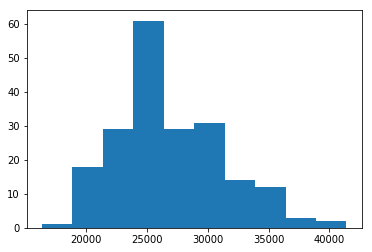

In [6]:
# how many points in kitti after radius cutoff
def make_dataset_kitti(root):
    seq_list = list(range(11))

    # filter or not
    np_folder = 'np_0.20_20480_r90_sn'
        
    accumulated_sample_num = 0
    sample_num_list = []
    accumulated_sample_num_list = []
    folder_list = []
    for seq in seq_list:
        folder = os.path.join(root, 'data_odometry_velodyne', 'numpy', '%02d'%seq, np_folder)
        folder_list.append(folder)
        
        sample_num = round(len(os.listdir(folder)))
        accumulated_sample_num += sample_num
        sample_num_list.append(sample_num)
        accumulated_sample_num_list.append(round(accumulated_sample_num))
        
    return seq_list, folder_list, sample_num_list, accumulated_sample_num_list


# statistics of Farthest Point Sampling, KITTI
sampler = FarthestSampler()
radius_cutoff = 50

seq_list, folder_list, sample_num_list, accumulated_sample_num_list = make_dataset_kitti('/ssd/jiaxin/dataset/odometry')
num_list = []
for i in range(0, 20000, 100):

    for idx, accumulated_sample_num in enumerate(accumulated_sample_num_list):
        if i < accumulated_sample_num:
            break
    folder = folder_list[idx]
    seq = seq_list[idx]

    if idx == 0:
        index_in_seq = i
    else:
        index_in_seq = i - accumulated_sample_num_list[idx-1]
    pc_np_file = os.path.join(folder, '%06d.npy' % index_in_seq)
    pc = np.load(pc_np_file)
    

    # point cloud z cutoff
    valid_index = np.linalg.norm(pc[:, [0, 2]], axis=1) < radius_cutoff
    pc = pc[valid_index, :]
    
    num_list.append(pc.shape[0])
plt.hist(num_list)
plt.show()

In [5]:
plt.show()

In [ ]:
for i in range(100):
    pc, pose = load_pc_and_pose_kitti(0, i)
    
    reflectance = pc[:, 3]
    print(np.mean(reflectance))
    print(np.max(reflectance))
    print(np.min(reflectance))
    print('---')

In [ ]:
print(np.linalg.norm([1,1]))

In [ ]:
# make Oxford dataset
def make_dataset_oxford(txt_path):
    f = open(txt_path, 'r')
    lines_list = f.readlines()
    
    dataset = []
    for i, line_str in enumerate(lines_list):
        # convert each line to a dict
        line_splitted_list = line_str.split('|')
        try:
            assert len(line_splitted_list) == 3
        except Exception:
            print('Invalid line.')
            print(i)
            print(line_splitted_list)
            continue
        
        file_name = line_splitted_list[0].strip()
        positive_lines = list(map(int, line_splitted_list[1].split()))
        non_negative_lines = list(map(int, line_splitted_list[2].split()))
        
#         print(file_name)
#         print(positive_lines)
#         print(non_negative_lines)

        data = {'file': file_name[0:-3]+'npy', 'pos_list': positive_lines, 'nonneg_list': non_negative_lines}
        dataset.append(data)
        
    f.close()
    return dataset

In [ ]:
# statistics of Farthest Point Sampling, Oxford
sampler = FarthestSampler()
radius_cutoff = 50
k = 256

train_folder_path = '/ssd/dataset/oxford/train_np'
train_txt_path = '/ssd/dataset/oxford/train_relative.txt'
dataset = make_dataset_oxford(train_txt_path)

mean_list = []
min_list = []
max_list = []
for i in range(0, 20000, 100):

    pc_file = dataset[i]['file']
    pc_np = np.load(os.path.join(train_folder_path, pc_file))

    # point cloud z cutoff
    valid_index = np.linalg.norm(pc[:, [0, 2]], axis=1) < radius_cutoff
    pc = pc[valid_index, :]

    # point cloud random sampling
    pc = pc[np.random.choice(pc.shape[0], 16384, replace=False), :]

    farthest_pts = sampler.sample(pc[:, 0:3], k)

    # visualization
#     fig = plt.figure(figsize=(9, 9))
#     ax = Axes3D(fig)
#     ax = plot_pc(pc, color=[0, 0, 1], ax=ax)
#     ax = plot_pc(farthest_pts, color=[1, 0, 0], size=3, ax=ax)
#     plt.show()

    # nearest neighbor analysis for point cloud
#     knn_k=2
#     knn = KNNBuilder(k=knn_k)

#     index = knn.build_nn_index(np.ascontiguousarray(pc[:, 0:3], dtype=np.float32))
#     D, I = knn.search_nn(index, np.ascontiguousarray(pc[:, 0:3], dtype=np.float32), k=knn_k)

#     D = np.sqrt(np.fabs(D))
#     D = D[:, knn_k-1:knn_k]
#     print('pc k=%d - mean %f, max %f, min %f' % (knn_k, np.mean(D), np.max(D), np.min(D)))
    
    
    # nearest neighbor analysis for nodes
    knn_k=2
    knn = KNNBuilder(k=knn_k)

    index = knn.build_nn_index(np.ascontiguousarray(farthest_pts[:, 0:3], dtype=np.float32))
    D, I = knn.search_nn(index, np.ascontiguousarray(farthest_pts[:, 0:3], dtype=np.float32), k=knn_k)

    D = np.sqrt(np.fabs(D))
    D = D[:, knn_k-1:knn_k]
    
    mean_list.append(np.mean(D))
    max_list.append(np.max(D))
    min_list.append(np.min(D))
#     print('node k=%d - mean %f, max %f, min %f \n' % (knn_k, np.mean(D), np.max(D), np.min(D)))
    

node_knn_mean = np.mean(np.asarray(mean_list))
node_knn_min = np.mean(np.asarray(min_list))
node_knn_max = np.mean(np.asarray(max_list))
print('node k=%d - mean %f, max %f, min %f \n' % (knn_k, node_knn_mean, node_knn_max, node_knn_min))